# Multi-class Classification (Word Embeddings)

In this notebook I am apply different machine learning models to predict the skills that I need from the job descriptions.

## Table of contents

1. [Environment Preparation](#Environment-Preparation)
   1. [Dataset Loading](#Dataset-Loading)
   2. [Undersampling](#Undersampling)
   3. [Tensorflow Datasets](#Tensorflow-Datasets)
   4. [Text Preprocessing](#Text-Preprocessing)
2. [Word Embeddings](#Word-Embeddings)
   1. [Model Configuration](#Model-Configuration)
   2. [Callbacks](#Callbacks)
   3. [Training](#Training)
   4. [Results and Visualizations](#Results-and-Visualizations)
3. [Export the Model](#Export-the-Model)

## Environment Preparation

### Dataset Loading

In [1]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [2]:
import io
import random
import numpy as np
import pandas as pd                # Data processing

# Visualization imports
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
sns.set_theme()                    # Seaborn will handle plotting theme
%matplotlib inline

# Scikit-learn imports
from sklearn.model_selection import train_test_split

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

In [3]:
df = pd.read_csv('noun_chunks_classified.csv')
df['type'].value_counts()

not_skill     3406
hard_skill     524
soft_skill      70
Name: type, dtype: int64

### Undersampling

Like in a previous notebook, we are going to perform undersampling on the most available data.

In [4]:
df_skills     = df[df['type'] != "not_skill"]
df_not_skills = df[df['type'] == "not_skill"].sample(n=len(df_skills))
df = pd.concat([df_skills, df_not_skills], ignore_index=True)

In [5]:
test_ratio = 0.4

# Extract features and prediction vectors
X = df['chunks']
y = df['type'].map({'not_skill':0, 'hard_skill':1, 'soft_skill':2})

# Split into train, test and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = test_ratio, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)
    
X_train.shape, X_test.shape, X_val.shape

((712,), (238,), (238,))

Let's observe the maximum length of words in our `X` column.

In [6]:
X.str.split().str.len().max()

18

### Tensorflow Datasets

In [7]:
# Prepare the training dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(64)

# Prepare the testing dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(64)

As per tensorflow tutorial: https://www.tensorflow.org/text/guide/word_embeddings#configure_the_dataset_for_performance

`.cache()` Keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` Overlaps data preprocessing and model execution while training.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Let's understand how the tensorflow dataset is constructed:

In [9]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print("Label:", label_batch[i].numpy(), "\tText:", text_batch.numpy()[i])

Label: 0 	Text: b'class results'
Label: 0 	Text: b'the Product Management Department'
Label: 2 	Text: b'highly motivated people'
Label: 0 	Text: b'Pharma Life Science commercial functional knowledge'
Label: 0 	Text: b'their needs'


### Text Preprocessing

In [10]:
# Custom standardization function to strip remove uneccessary text and symbols.
def custom_standardization(input_data):
    input_df = tf.strings.lower(input_data)
    input_df = tf.strings.regex_replace(input_df, '(e.g.?)|(i.e.?).', '')
    input_df = tf.strings.regex_replace(input_df, '[^\u0020-\u007E]', ' ')
    input_df = tf.strings.regex_replace(input_df, '\b[\w\.-]+@[\w\.-]+\.\w{2,6}\b', '')
    input_df = tf.strings.regex_replace(input_df, '(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '')
    input_df = tf.strings.regex_replace(input_df, '\B#([a-z0-9]{1,})', ' ')
    input_df = tf.strings.regex_replace(input_df, '[^\w\s+#]', ' ')
    
    return tf.strings.regex_replace(input_df, '(\s{2,})|(\n+)', ' ')

In [11]:
# Vocabulary size and number of words in a sequence.
vocab_size = 2500
sequence_length = 20

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(X_train)

In [12]:
vocabulary = vectorize_layer.get_vocabulary()
print('Vocabulary size: {}'.format(len(vocabulary)))

num = random.randint(1, len(vocabulary))
print(f"Word number {num} --->", vocabulary[num])

Vocabulary size: 965
Word number 918 ---> assurance


## Word Embeddings

Word embeddings are a way of representing words as dense vectors of real numbers. They are used in natural language processing (NLP) to encode
words in a way that allows them to be used as input to machine learning models.

The main advantage of word embeddings is that they allow us to use an efficient, dense representation in which similar words have a similar
encoding. This makes it possible to use machine learning algorithms to analyze text data and perform tasks such as sentiment analysis, text
classification, and machine translation.

### Model Configuration

I will now create a model using TensorFlow’s Keras API. I define a neural network model that takes a string as input and outputs a probability
distribution over three classes. In more detail:

1. `embedding_dim`: Sets the dimensionality of the word embeddings that will be learned by the model to 16.
2. `tf.keras.Input()`: This line defines an input layer that takes a string as input.
3. `vectorize_layer`: Defines a layer that converts the input string into a sequence of integers.
4. `Embedding()`: Defines an embedding layer that maps each integer in the input sequence to a dense vector of dimensionality `embedding_dim`.
5. `GlobalAveragePooling1D()`: Applies global average pooling to the output of the embedding layer.
6. `Dense(16, activation='relu')`: Adds a fully connected layer with 16 units and ReLU activation.
7. `Dense(3, activation='softmax')`: Adds a fully connected layer with 3 units and softmax activation, which outputs a probability distribution over three classes.

In [13]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 20)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 20, 16)            40000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 40,323
Trainable params: 40,323
Non-traina

Let's compile our machine learning model. I used the `Adam` optimizer, which is an algorithm for gradient-based optimization of
stochastic objective functions. It's a popular optimization algorithm used in deep learning because it’s computationally efficient
and requires little memory.

The `Sparse Categorical Crossentropy` loss function is used for multi-class classification problems where
there are two or more label classes.

Lastly I use the `accuracy` as the metric to evaluate the model’s performance.

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Callbacks

The `EarlyStopping` callback is used to stop training when a monitored metric has stopped improving.

Here it's monitoring the validation loss and will stop training if the validation loss doesn't improve after 5 epochs starting from epoch 15.

In [16]:
tf_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=15, verbose=1)
]

### Training

In [17]:
NUM_EPOCHS = 200
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS, callbacks=tf_callbacks)

Epoch 1/200
12/12 [==============================] - 3s 51ms/step - loss: 1.0720 - accuracy: 0.5000 - val_loss: 1.0451 - val_accuracy: 0.5252
Epoch 2/200
12/12 [==============================] - 0s 12ms/step - loss: 1.0356 - accuracy: 0.4986 - val_loss: 1.0047 - val_accuracy: 0.5210
Epoch 3/200
12/12 [==============================] - 0s 11ms/step - loss: 1.0008 - accuracy: 0.5000 - val_loss: 0.9654 - val_accuracy: 0.5210
Epoch 4/200
12/12 [==============================] - 0s 14ms/step - loss: 0.9679 - accuracy: 0.5014 - val_loss: 0.9278 - val_accuracy: 0.5210
Epoch 5/200
12/12 [==============================] - 0s 12ms/step - loss: 0.9375 - accuracy: 0.5028 - val_loss: 0.8929 - val_accuracy: 0.5252
Epoch 6/200
12/12 [==============================] - 0s 11ms/step - loss: 0.9114 - accuracy: 0.5042 - val_loss: 0.8638 - val_accuracy: 0.5252
Epoch 7/200
12/12 [==============================] - 0s 12ms/step - loss: 0.8912 - accuracy: 0.5126 - val_loss: 0.8412 - val_accuracy: 0.5378
Epoch 

In [18]:
loss, accuracy = model.evaluate(test_ds)
print(f'Loss: {loss}, Accuracy: {accuracy}')

4/4 [==============================] - 0s 3ms/step - loss: 0.5140 - accuracy: 0.8361
Loss: 0.5140182375907898, Accuracy: 0.8361344337463379


We see at this point that our naive model achieves an accuracy of 0.75 and a loss of 0.64. This model behaves poorly.
Another observation we can make is that this simple model is overfitting the data, as the training set accuracy is higher than the validation set accuracy.

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

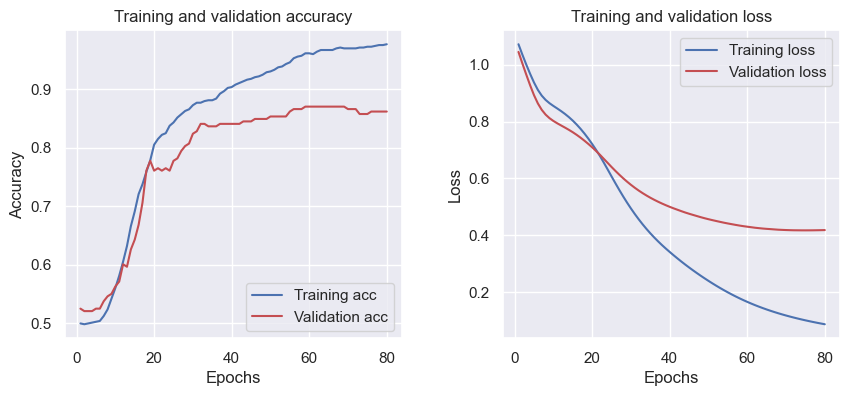

In [20]:
acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.3)

axes[0].plot(epochs, acc, 'b', label='Training acc')
axes[0].plot(epochs, val_acc, 'r', label='Validation acc')

axes[0].set_title('Training and validation accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')

axes[1].plot(epochs, loss, 'b', label='Training loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation loss')

axes[1].set_title('Training and validation loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

### Results and Visualizations

In [21]:
weights = model.get_layer('embedding').get_weights()[0]

inverse_voc = {}
for index, word in enumerate(vocabulary):
    inverse_voc[word] = index

In [22]:
from numpy.linalg import norm

# Function that accepts a word and returns the num most similar words to the given one
def most_similar(word, num):
    similar = []
    word_w = weights[inverse_voc[word]]
    for key, value in inverse_voc.items():
        if word == key:
            continue
        cosine = np.dot(word_w, weights[inverse_voc[key]])/(norm(word_w)*norm(weights[inverse_voc[key]]))
        similar.append((key, cosine))
        
    similar.sort(key=lambda x: x[1], reverse=True)
    #similar = sorted(similar, key=float, reverse=True)
        
    return similar[:num]

In [23]:
most_similar('python', 10)

[('pytorch', 0.99759275),
 ('azure', 0.9975668),
 ('sql', 0.9973974),
 ('gnn', 0.9968368),
 ('languages', 0.99665177),
 ('concepts', 0.99660146),
 ('programming', 0.99632293),
 ('aws', 0.9960994),
 ('kubernetes', 0.9960301),
 ('senior', 0.9959988)]

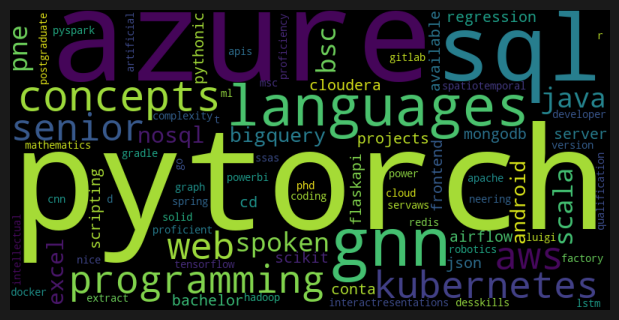

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = {x[0]: x[1] for x in most_similar('python', 100)}
wordcloud = WordCloud(width=800, height=400, min_font_size=12).generate_from_frequencies(text)

plt.figure( figsize=(6, 5), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

As you can see, our model can actually identify most of the hard skills and tools that we are insterested in by specifying 'python' as our target word.

Of course, we also get some noise data, and this is probably due to the fact that our dataset is rather small.

## Export the Model

The exported model weights and metadata can be used to visualize the vector space here:
http://projector.tensorflow.org/

In [25]:
out_v = io.open('tf_we_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('tf_we_metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocabulary):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()